In [1]:
!pip install scipy==1.6.3
!pip install scikit_optimize==0.8.1
!pip install scikit_learn==0.24.2
! git clone https://github.com/zykhoo/SeparableNNs.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 27.4 MB 1.5 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 101 kB 3.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import numpy as np

experiment,sys,dim = "NN","TodaLatticeNA",6
f1 = lambda x: np.asarray([x[3], x[4], x[5]])
f2 = lambda x: np.asarray([-np.exp(x[0]-x[1])+np.exp(x[2]-x[0]),
                           -np.exp(x[1]-x[2])+np.exp(x[0]-x[1]),
                           -np.exp(x[2]-x[0])+np.exp(x[1]-x[2]),])
H = lambda x: 0.5*(x[3]**2+x[4]**2+x[5]**2)+np.exp(x[0]-x[1])+np.exp(x[1]-x[2])+np.exp(x[2]-x[0])-3

spacedim = [(-0.5,0.5),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5),(-0.5,0.5)] # by using this spacedim, x<1 therefore x**2<1. the hamiltonian will usually be negative.
h= 0.01
x0, H0 = 0.,0.
initialcon = [64, 128, 256, 512, 1024, 2048] #, 4096, 8192
LR=0.01

"""# Test dataset creation"""

from SeparableNNs import groundtruth_2dim
from tqdm import tqdm
import time 

# xxshort,yyshort = np.linspace(spacedim[0][0], spacedim[0][1], 20), np.linspace(spacedim[1][0], spacedim[1][1], 20)
# xshort,yshort = np.meshgrid(xxshort,yyshort)

# H_true = H(np.c_[np.ravel(xshort),np.ravel(yshort)].transpose())
# sample_points = np.expand_dims(np.c_[np.ravel(xshort),np.ravel(yshort)],2)

# def get_H_grad(model, z,device):
#     inputs=torch.unsqueeze(Variable(torch.tensor([z[0][0],z[1][0]]), requires_grad = True),0).to(device)
#     out=model(inputs.float())
#     dH=torch.autograd.grad(out, inputs, grad_outputs=out.data.new(out.shape).fill_(1),create_graph=True, allow_unused=True)[0].detach().cpu().numpy()
#     return out.detach().cpu().numpy(), dH[0][1],-dH[0][0] # negative dH/dq is dp/dt

In [4]:
# NN takes in p, q, dq, dp, and learns the Hamiltonian. The derivative of the Hamiltonian is used for integration

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.nn.utils.prune as prune
import numpy as np
import os
import time
from tqdm import tqdm
import math

# define model
def softplus(x):
    return torch.log(torch.exp(x)+1)

from sklearn.model_selection import train_test_split


# class sepNet(nn.Module):

#     def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
#         super(sepNet , self).__init__()
#         self.mask1 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(input_size/2))),torch.zeros((1,int(input_size/2)))),1),0).repeat(int(hidden_size1),1),
#             torch.squeeze(torch.cat((torch.zeros((1,int(input_size/2))),torch.ones((1,int(input_size/2)))),1),0).repeat(int(hidden_size1),1)),0)
#         self.mask2 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(hidden_size1))),torch.zeros((1,int(hidden_size1)))),1),0).repeat(int(hidden_size2),1),
#                     torch.squeeze(torch.cat((torch.zeros((1,int(hidden_size1))),torch.ones((1,int(hidden_size1)))),1),0).repeat(int(hidden_size2),1)),0)
#         self.mask3 = torch.cat((torch.squeeze(torch.cat((torch.ones((1,int(hidden_size2))),torch.zeros((1,int(hidden_size2)))),1),0).repeat(int(output_size),1),
#                     torch.squeeze(torch.cat((torch.zeros((1,int(hidden_size2))),torch.ones((1,int(hidden_size2)))),1),0).repeat(int(output_size),1)),0)
#         self.hidden_layer_1 = nn.Linear( input_size, hidden_size1*2, bias=True)
#         with torch.no_grad():
#             self.hidden_layer_1.weight.mul_(self.mask1)
#         self.hidden_layer_2 = nn.Linear( hidden_size1*2, hidden_size2*2, bias=True)
#         with torch.no_grad():
#             self.hidden_layer_2.weight.mul_(self.mask2)
#         self.output_layer = nn.Linear( hidden_size2*2, output_size*2 , bias=True)
#         with torch.no_grad():
#             self.output_layer.weight.mul_(self.mask3)
#         prune.custom_from_mask(self.hidden_layer_1, name='weight', mask=self.mask1)
#         prune.custom_from_mask(self.hidden_layer_2, name='weight', mask=self.mask2)
#         prune.custom_from_mask(self.output_layer, name='weight', mask=self.mask3)
        
#     def forward(self, x):
#         x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
#         x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
#         x = self.output_layer(x)
#         x = torch.sum(x)
#         return x


# PINN
class Net(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(Net , self).__init__()
        self.hidden_layer_1 = nn.Linear( input_size, hidden_size, bias=True)
        self.hidden_layer_2 = nn.Linear( hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear( hidden_size, output_size , bias=True)
        
    def forward(self, x):
        x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
        x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
        x = self.output_layer(x)

        return x

class SumNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(SumNet , self).__init__()
        self.hidden_layer_1 = nn.Linear( input_size, hidden_size, bias=True)
        self.hidden_layer_2 = nn.Linear( hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear( hidden_size, 2 , bias=True)
        
    def forward(self, x):
        x = softplus(self.hidden_layer_1(x)) # F.relu(self.hidden_layer_1(x)) # 
        x = softplus(self.hidden_layer_2(x)) # F.relu(self.hidden_layer_2(x)) # 
        x = self.output_layer(x)
        x = torch.sum(x)

        return x

# calculate loss
def lossfuc(model,mat,x,y,device,x0,H0,dim,c1=1,c2=1,c3=1,c4=1,verbose=False):
    dim = int(wholemat.shape[1]/2)
    f3=(model(torch.tensor([[x0]*dim]).to(device))-torch.tensor([[H0]]).to(device))**2
    dH=torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1),create_graph=True, allow_unused=True)[0]
    dHdq=dH[:,:int(dim/2)]
    dHdp=dH[:,int(dim/2):]
    qprime=(mat[:,dim:int(3*dim/2)])
    pprime=(mat[:,int(3*dim/2):])
    assert dHdq.shape[1] == int(dim/2)
    assert dHdp.shape[1] == int(dim/2)
    assert qprime.shape[1] == int(dim/2)
    assert pprime.shape[1] == int(dim/2)
    f1=torch.mean((dHdp-qprime)**2,dim=0)
    # print(dHdq, pprime)
    f2=torch.mean((dHdq+pprime)**2,dim=0)
    f4=torch.mean((dHdq*qprime+dHdp*pprime)**2,dim=0)
    loss=torch.mean(c1*f1+c2*f2+c3*f3+c4*f4)
    if loss > 1000: print("errors:", f1, f2, f3, f4)
    meanf1,meanf2,meanf3,meanf4=torch.mean(c1*f1),torch.mean(c2*f2),torch.mean(c3*f3),torch.mean(c4*f4)
    if verbose:
      print(x)
      print(meanf1,meanf2,meanf3,meanf4)
      print(loss,meanf1,meanf2,meanf3,meanf4)
    return loss,meanf1,meanf2,meanf3,meanf4


def data_preprocessing(start_train, final_train,device):       
    # wholemat=[]
    # for i in range(len(start_train[0,:])):
    #     wholemat.append(np.vstack((
    #         np.hstack((start_train[:,i], (final_train[:,i]-start_train[:,i])/h)),
    #         np.hstack((final_train[:,i], (final_train[:,i]-start_train[:,i])/h)))))
    wholemat = np.hstack((start_train.transpose(), final_train.transpose()))

    wholemat =torch.tensor(wholemat)
    wholemat=wholemat.to(device)

    wholemat,evalmat=train_test_split(wholemat, train_size=0.8, random_state=1)

    return wholemat,evalmat

## train

# evaluate loss of dataset 
def get_loss(model,device,initial_conditions,bs,x0,H0,dim,wholemat,evalmat,c1,c2,c3,c4,trainset=False,verbose=False):
    # this function is used to calculate average loss of a whole dataset
    # rootpath: path of set to be calculated loss
    # model: model
    # trainset: is training set or not


    if trainset:
        mat=wholemat
    else:
        mat=evalmat
    avg_loss=0
    avg_f1=0
    avg_f2=0
    avg_f3=0
    avg_f4=0
    for count in range(0,len(mat),bs):
      curmat=mat[count:count+bs]
      x=Variable((curmat[:,:dim]).float(),requires_grad=True)
      y=model(x)
      x=x.to(device)
      loss,f1,f2,f3,f4=lossfuc(model,curmat,x,y,device,x0,H0,dim,c1,c2,c3,c4)
      avg_loss+=loss.detach().cpu().item()
      avg_f1+=f1.detach().cpu().item()
      avg_f2+=f2.detach().cpu().item()
      avg_f3+=f3.detach().cpu().item()
      avg_f4+=f4.detach().cpu().item()
    num_batches=len(mat)//bs
    avg_loss/=num_batches
    avg_f1/=num_batches
    avg_f2/=num_batches
    avg_f3/=num_batches
    avg_f4/=num_batches
    if verbose:
        print(' loss=',avg_loss,' f1=',avg_f1,' f2=',avg_f2,' f3=',avg_f3,' f4=',avg_f4)
    return avg_loss


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            上次验证集损失值改善后等待几个epoch
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            如果是True，为每个验证集损失值改善打印一条信息
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            监测数量的最小变化，以符合改进的要求
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if abs(self.counter-self.patience)<5:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''
        Saves model when validation loss decrease.
        验证损失减少时保存模型。
        '''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), 'checkpoint.pt')     # 这里会存储迄今最优模型的参数
        torch.save(model, 'checkpoint.pt')                 # 这里会存储迄今最优的模型
        self.val_loss_min = val_loss

def train(net,bs,num_epoch,initial_conditions,device,wholemat,evalmat,x0,H0,dim,LR,patience,c1,c2,c3,c4):
    # function of training process
    # net: the model
    # bs: batch size 
    # num_epoch: max of epoch to run
    # initial_conditions: number of trajectory in train set
    # patience: EarlyStopping parameter
    # c1~c4: hyperparameter for loss function


    avg_lossli,avg_f1li,avg_f2li,avg_f3li,avg_f4li=[],[],[],[],[]
    avg_vallosses=[]
    
    start = time.time()
    lr = LR # initial learning rate
    net=net.to(device)

    early_stopping = EarlyStopping(patience=patience, verbose=False,delta=0.00001) # delta
    optimizer=torch.optim.Adam(net.parameters() , lr=lr )
    for epoch in range(num_epoch):

        running_loss=0

        running_f1=0
        running_f2=0
        running_f3=0
        running_f4=0
        num_batches=0
        
        # train
        shuffled_indices=torch.randperm(len(wholemat))
        net.train()
        for count in range(0,len(wholemat),bs):
            optimizer.zero_grad()

            indices=shuffled_indices[count:count+bs]
            mat=wholemat[indices]

            x=Variable(torch.tensor(mat[:,:dim]).float(),requires_grad=True)
            y=net(x)

            loss,f1,f2,f3,f4=lossfuc(net,mat,x,y,device,x0,H0,dim,c1,c2,c3,c4)  
            loss.backward()
            torch.nn.utils.clip_grad_norm(net.parameters(), 1)

            optimizer.step()

            # compute some stats
            running_loss += loss.detach().item()
            running_f1 += f1.detach().item()
            running_f2 += f2.detach().item()
            running_f3 += f3.detach().item()
            running_f4 += f4.detach().item()

            num_batches+=1
            torch.cuda.empty_cache()



        avg_loss = running_loss/num_batches
        avg_f1 = running_f1/num_batches
        avg_f2 = running_f2/num_batches
        avg_f3 = running_f3/num_batches
        avg_f4 = running_f4/num_batches
        elapsed_time = time.time() - start
        
        avg_lossli.append(avg_loss)
        avg_f1li.append(avg_f1)
        avg_f2li.append(avg_f2)
        avg_f3li.append(avg_f3)
        avg_f4li.append(avg_f4)
        
        
        # evaluate
        net.eval()
        avg_val_loss=get_loss(net,device,len(evalmat),bs,x0,H0,dim,wholemat,evalmat,c1,c2,c3,c4)
        avg_vallosses.append(avg_val_loss)
        
        if epoch % 100 == 0 : 
            print(' ')
            print('epoch=',epoch, ' time=', elapsed_time,
                  ' loss=', avg_loss ,' val_loss=',avg_val_loss,' f1=', avg_f1 ,' f2=', avg_f2 ,
                  ' f3=', avg_f3 ,' f4=', avg_f4 , 'num_batches=', num_batches, 'percent lr=', optimizer.param_groups[0]["lr"] )
        
        
        
        early_stopping(avg_val_loss,net)
        if early_stopping.early_stop:
            print('Early Stopping')
            break
            
    net=torch.load('checkpoint.pt')
    return net,epoch,avg_vallosses,avg_lossli,avg_f1li,avg_f2li,avg_f3li,avg_f4li

class splitBalancedLinear(nn.Module):

    def __init__(self, input_size, output_size):
        # output_size is the size of one of the two parallel networks
        super(splitBalancedLinear , self).__init__()
        self.input_size, self.output_size = input_size, output_size
        weights = torch.Tensor(2,self.input_size,self.output_size)
        self.weights = nn.Parameter(weights)
        bias = torch.Tensor(2,1,self.output_size)
        self.bias = nn.Parameter(bias)

        # initialise weights and bias
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) 
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)  # bias init
        
    def forward(self, x):
        # print(self.weights, self.bias)
        # print("mul", torch.einsum('ijk,ikl->ijl', x, self.weights))
        # print("add", torch.add(torch.einsum('ijk,ikl->ijl', x, self.weights), self.bias))
        return torch.add(torch.einsum('ijk,ikl->ijl', x, self.weights), self.bias)
        # return F.linear(x, self.weights, self.bias)

class sepNet(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(sepNet , self).__init__()
        self.hidden_layer_1 = splitBalancedLinear(input_size, hidden_size1)
        self.hidden_layer_2 = splitBalancedLinear(hidden_size1, hidden_size2)
        self.output_layer = splitBalancedLinear(hidden_size2, output_size)
        
    def forward(self, x):
        # print("input", x.shape)
        # print(x)
        x = torch.stack((x[:,:int(x.shape[-1]/2)],x[:,int(x.shape[-1]/2):]))
        # print(x)
        # print("initial", x.shape)
        x = softplus(self.hidden_layer_1(x)) 
        # print(x)
        # print("hl1", x.shape)
        x = softplus(self.hidden_layer_2(x)) 
        # print(x)
        # print("hl2", x.shape)
        x = self.output_layer(x)
        # print(x)
        # print("output", x.shape)
        x = torch.sum(x)
        return x

In [9]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
from matplotlib import cm
from SeparableNNs.models import PINN
import torch
from SeparableNNs import metrics

for i in range(20):
  seed = i
  np.random.seed(seed=seed)
  for ini in initialcon: 

    start, final = groundtruth_2dim.CreateTrainingDataTrajStormer(1,ini,spacedim,h,f1,f2,seed = seed,n_h = 1)

    delta = (final-start)/h

    # delta2 = delta.copy()
    # delta2[0,:] = f1(start)
    # delta2[1,:] = f2(start)
    # dq_MSE = np.mean(np.square(delta2[0,:]-delta[0,:]))
    # dp_MSE = np.mean(np.square(delta2[1,:]-delta[1,:]))
    # data_MSE = np.mean(np.square(np.sqrt(delta[0,:]**2 + delta[1,:]**2)-np.sqrt(delta2[0,:]**2 + delta2[1,:]**2)))

    """# sepNN"""

    

    if torch.cuda.is_available():
      device=torch.device('cuda')
    else:
      device=torch.device('cpu')
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    wholemat, evalmat = PINN.data_preprocessing(start, delta,device)    

    import torch.optim as optim
    import time 


    sepnet = sepNet(3,22,22,1) #sepnet = sepNet(3,22,22,1)
    starttime = time.time() 
    print("training sepNet")

    results = train(sepnet,bs=min(int(len(wholemat)/5), 128),num_epoch=7000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=1000,c1=1,c2=1,c3=1,c4=1)
    # results = PINN.train(sepnet,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
    sepnet, epochs = results[0], results[1]
    septraintime = time.time()-starttime
    torch.save(sepnet.state_dict(), '/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"sepNN",seed,ini))

    # H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    # for i in tqdm(range(len(sample_points))):
    #   out = get_H_grad(sepnet, sample_points[i], device)
    #   H_pred[i] = out[0]
    #   dq_pred[i] = out[1]
    #   dp_pred[i] = out[2]
    # print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    # file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_results.txt' %(sys,sys), 'a') 
    # file_object.write('sepNN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
    #       %(ini, seed, dq_MSE, dp_MSE, data_MSE, septraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
    #       np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
    #       np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    # file_object.close()
    
    # H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)

    # plt.figure(figsize = (10,10))
    # plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    # plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    # plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "sepNN"))

    net = Net(6,31,1)
    starttime = time.time() 
    print("training PINN Net")
    
    results = train(net,bs=min(int(len(wholemat)/5), 128),num_epoch=7000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=1000,c1=1,c2=1,c3=1,c4=1)
    net, epochs = results[0], results[1]
    PINNtraintime = time.time()-starttime
    torch.save(net.state_dict(), '/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini))

    # H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    # for i in tqdm(range(len(sample_points))):
    #   out = get_H_grad(net, sample_points[i], device)
    #   H_pred[i] = out[0]
    #   dq_pred[i] = out[1]
    #   dp_pred[i] = out[2]
    # print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    # file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_results.txt' %(sys,sys), 'a')
    # file_object.write('PINN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
    #       %(ini, seed, dq_MSE, dp_MSE, data_MSE, PINNtraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
    #       np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
    #       np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    # file_object.close()
    
    # H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)
    
    # plt.figure(figsize = (10,10))
    # plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    # plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    # plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "PINN"))

    # print(septraintime, PINNtraintime)

training sepNet
 
epoch= 0  time= 0.0499269962310791  loss= 0.8156177493246966  val_loss= 1.6673306948689337  f1= 0.08436499573090421  f2= 0.5926381899021811  f3= 0.13861295842798427  f4= 1.6052636269355164e-06 num_batches= 6 percent lr= 0.01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:258: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:263: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Streaming output truncated to the last 5000 lines.
epoch= 500  time= 14.049264430999756  loss= 0.001489777162183898  val_loss= 0.044147797345427064  f1= 0.0001331890320602949  f2= 0.0011034869641264268  f3= 6.707233770460637e-06  f4= 0.0002463939322267157 num_batches= 6 percent lr= 0.01
 
epoch= 600  time= 16.444827556610107  loss= 0.0007714379705931284  val_loss= 0.04035912640176676  f1= 8.537012715226194e-05  f2= 0.0005993275670477758  f3= 9.217975929232125e-06  f4= 7.752230046385843e-05 num_batches= 6 percent lr= 0.01
 
epoch= 700  time= 18.866371154785156  loss= 0.0005282497639761166  val_loss= 0.040891251029117726  f1= 5.8561198226499794e-05  f2= 0.0003865403093273394  f3= 2.535288983078014e-05  f4= 5.7795366591497364e-05 num_batches= 6 percent lr= 0.01
 
epoch= 800  time= 21.23860740661621  loss= 0.0017911355316557048  val_loss= 0.03877473855530818  f1= 0.00015632343859446079  f2= 0.0006182772661935715  f3= 0.0008709435254180183  f4= 0.00014559130144965436 num_batches= 6 percent 

In [ ]:
# n_sample = 20
# dim = 6

# z = torch.tensor(np.array(np.meshgrid(np.linspace(spacedim[0][0], spacedim[0][1], n_sample),np.linspace(spacedim[1][0], spacedim[1][1],n_sample),
#                                       np.linspace(spacedim[2][0], spacedim[2][1],n_sample),np.linspace(spacedim[3][0], spacedim[3][1],n_sample),
#                                       np.linspace(spacedim[4][0], spacedim[4][1],n_sample),np.linspace(spacedim[5][0], spacedim[5][1],n_sample),
#                                       ))).reshape(6, n_sample**dim).transpose(1,0)
# for i in tqdm(range(dim**2)):
#   np.savetxt('/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/test%s.txt' %(sys,i), z[n_sample**4*i:n_sample**4*(i+1), :])

100%|██████████| 36/36 [00:50<00:00,  1.42s/it]


In [12]:
from tqdm import tqdm

n_sample = 20 # 6

sepnet_total, net_total = [],[]
for seed in tqdm(range(20)):
  for ini in initialcon:
    net = Net(6,31,1)
    net.load_state_dict(torch.load('/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini)))

    sepnet = sepNet(3,22,22,1) #PINN.sepNet(2,11,11,1)
    sepnet.load_state_dict(torch.load('/content/drive/MyDrive/CIKM2022/Toda Lattice/%s/%s_%s_%s_%s.pt' %(sys,sys,"sepNN",seed,ini)))

    def get_grad(model, z,device):
      inputs=Variable(z.clone().detach()).requires_grad_(True).to(device)
      out=model(inputs.float())
      dH=torch.autograd.grad(out, inputs, grad_outputs=out.data.new(out.shape).fill_(1),create_graph=True)[0]
      return np.asarray([dH.detach().cpu().numpy()[:,3], dH.detach().cpu().numpy()[:,4], dH.detach().cpu().numpy()[:,5],
                         -dH.detach().cpu().numpy()[:,0], -dH.detach().cpu().numpy()[:,1], -dH.detach().cpu().numpy()[:,2], ]) # negative dH/dq is dp/dt
      # return np.asarray([dH.detach().to(device).numpy()[:,3], dH.detach().to(device).numpy()[:,4], dH.detach().to(device).numpy()[:,5],
      #               -dH.detach().to(device).numpy()[:,0], -dH.detach().to(device).numpy()[:,1], -dH.detach().to(device).numpy()[:,2], ]) # negative dH/dq is dp/dt

    
    f1 = lambda x: np.stack([x[:,3], x[:,4], x[:,5]])
    f2 = lambda x: np.stack([-np.exp(x[:,0]-x[:,1])+np.exp(x[:,2]-x[:,0]),
                              -np.exp(x[:,1]-x[:,2])+np.exp(x[:,0]-x[:,1]),
                              -np.exp(x[:,2]-x[:,0])+np.exp(x[:,1]-x[:,2]),])

    fvec = lambda z: np.concatenate([f1(z), f2(z)])
    error = lambda x,y: np.sum(np.sqrt(np.sum((x-y)**2,0))/np.sqrt(np.sum(x**2,0))) # where x is the true vector and y is the approximated vector

    # z = torch.tensor(np.array(np.meshgrid(np.linspace(spacedim[0][0], spacedim[0][1], n_sample),np.linspace(spacedim[1][0], spacedim[1][1],n_sample),
    #                                   np.linspace(spacedim[2][0], spacedim[2][1],n_sample),np.linspace(spacedim[3][0], spacedim[3][1],n_sample),
    #                                   np.linspace(spacedim[4][0], spacedim[4][1],n_sample),np.linspace(spacedim[5][0], spacedim[5][1],n_sample),
    #                                   ))).reshape(6, n_sample**dim).transpose(1,0)
    

    sepnet_error, net_error = 0, 0
    for i in range(6**2):
      inpz = torch.tensor(np.loadtxt('/content/drive/MyDrive/CIKM2022/Toda Lattice/TodaLatticeNA/test%s.txt' %(i)))
      sepnet_error += error(fvec(inpz), get_grad(sepnet, inpz, 'cpu'))
      net_error += error(fvec(inpz), get_grad(net, inpz, 'cpu'))
    sepnet_total.append(sepnet_error)
    net_total.append(net_error)
    print(ini, net_error, sepnet_error)

  0%|          | 0/20 [00:00<?, ?it/s]

64 152979.80837910078 132521.3941246751
128 76321.76088304161 82851.41945046298
256 53284.43025027767 40441.535692907775
512 44534.193952855356 44277.80355345106
1024 43921.729492412924 22271.81791786496


  5%|▌         | 1/20 [07:56<2:30:53, 476.48s/it]

2048 32358.720894217484 20486.88120416685
64 185859.02040534723 62213.44449666965
128 82412.07766988406 93309.46166739534
256 59262.74686327801 71322.51028198075
512 55314.243036279615 52838.01686637831
1024 45065.055287298885 37815.62401722803


 10%|█         | 2/20 [15:51<2:22:43, 475.75s/it]

2048 42160.38329468493 29027.12829766424
64 126554.81102832206 73101.73168994597
128 107928.19117282091 54540.82732423015
256 59319.40619733977 40982.716662704595
512 49004.78432205006 45465.47237492118
1024 34447.04291325629 17771.21118423455


 15%|█▌        | 3/20 [23:50<2:15:12, 477.21s/it]

2048 38731.14614980335 22021.307644700446
64 202504.3162616047 131759.5061064728
128 86655.38961110589 70791.38062271816
256 50674.917804244185 37639.47688342976
512 57674.305342554675 34622.25948158185
1024 49478.867396167 28316.02932700603


 20%|██        | 4/20 [31:47<2:07:12, 477.00s/it]

2048 39645.830267862664 23767.338072235583
64 123317.37100533317 83263.12031704662
128 75488.74040069529 60080.18779070865
256 72359.24561614053 57567.9332550336
512 58514.91576542852 28523.00273262589
1024 36014.766624932956 25193.378706137686


 25%|██▌       | 5/20 [39:39<1:58:51, 475.41s/it]

2048 33135.91692523684 25053.5237849265
64 116248.31355452297 86975.70585775032
128 82481.1546616773 54063.94885877167
256 59370.56152640124 39845.13375627392
512 54254.13668753373 40654.154850887055
1024 44869.175332891435 25817.98225180421


 30%|███       | 6/20 [47:32<1:50:43, 474.54s/it]

2048 39284.3095244577 26105.859265473944
64 131609.89330141255 62819.58495256345
128 73975.55006324634 76647.85528941765
256 70860.24822554646 43372.8091750271
512 58877.605241460136 36486.56653601549
1024 48683.29908206608 26923.77846504452


 35%|███▌      | 7/20 [55:26<1:42:45, 474.24s/it]

2048 33704.25227499129 28329.772141624766
64 118399.59305116233 83016.88445296905
128 78874.88287758398 91789.72041236123
256 70088.37587278918 43623.429119108696
512 46790.37087804153 34711.04249357402
1024 36224.214445718404 31730.54869947319


 40%|████      | 8/20 [1:03:21<1:34:53, 474.42s/it]

2048 35897.87347578197 29921.806710554152
64 223862.26219768467 96033.22023382696
128 98335.34627313311 40786.65198716637
256 61907.869454577565 46382.0048972452
512 51784.5549348499 27913.91224489221
1024 40496.218935097975 33717.65301263065


 45%|████▌     | 9/20 [1:11:16<1:27:02, 474.78s/it]

2048 37658.93357929164 24430.158636320095
64 152536.69153679896 64214.362726360254
128 88588.19024407407 45722.584267670776
256 64012.35210554927 34267.56915117292
512 45112.62013954625 35682.79533083139
1024 38664.483793970314 24839.720897152303


 50%|█████     | 10/20 [1:19:12<1:19:11, 475.19s/it]

2048 36056.27231360752 25576.680774445627
64 169202.14016323286 90172.01440274168
128 96558.00857327555 74575.68164252497
256 87929.01481098871 42423.87442375359
512 51039.876730435484 58546.5070003594
1024 38488.75616350729 24217.473528703416


 55%|█████▌    | 11/20 [1:27:10<1:11:23, 475.99s/it]

2048 35863.23198934817 26873.8999171449
64 192468.75609229266 82210.57762801791
128 75708.44245741983 45894.92391870333
256 75219.20037809221 59086.3305148248
512 60957.740065249694 61816.84965100289
1024 48097.82470459412 30069.110263836592


 60%|██████    | 12/20 [1:35:06<1:03:27, 475.90s/it]

2048 35304.37831675836 30618.878361641804
64 309644.9039078916 82074.51232603543
128 81607.54085654812 36799.22105706351
256 56832.9393339005 39389.5818733508
512 53578.83090056056 30146.776753957274
1024 45539.968127168104 23955.258264352164


 65%|██████▌   | 13/20 [1:43:02<55:31, 475.99s/it]  

2048 39993.51804940203 25962.545268892063
64 111883.9320249987 106272.13519991995
128 106046.67279995252 46957.09651310445
256 67666.08231410726 34054.249513629875
512 57073.52454132843 33444.72293804163
1024 35916.45265039748 30414.556976105512


 70%|███████   | 14/20 [1:51:01<47:42, 477.01s/it]

2048 35947.5200027651 24389.782769341742
64 140897.37554008217 54353.85518984572
128 73744.58878806951 47312.94669444542
256 63534.53150624376 50642.94998591853
512 58488.25829935865 31122.470447551284
1024 40029.9920243028 27286.872858862138


 75%|███████▌  | 15/20 [1:58:59<39:45, 477.05s/it]

2048 36533.86564038876 27507.6577540221
64 156035.29186517664 187545.72823554464
128 105114.29741549128 73015.60099929353
256 69638.45827035033 45111.34249031647
512 59528.0096241003 41678.07828457342
1024 44989.82379992922 27728.22339909469


 80%|████████  | 16/20 [2:07:02<31:56, 479.02s/it]

2048 34623.419036494684 23581.23358946674
64 153777.8405277015 106274.11857310514
128 79306.0930547632 68077.79123733572
256 49505.71740970519 44093.10051518454
512 49321.17051954035 31205.95820841574
1024 43338.729859103754 22047.714936098364


 85%|████████▌ | 17/20 [2:15:03<23:58, 479.57s/it]

2048 37930.106621034 25561.392455896963
64 145169.3009360754 77625.55898569153
128 84466.55111627438 42719.75351071697
256 75802.21275322372 47474.975048519234
512 46845.934350356474 23935.907865403475
1024 39896.59560374557 19888.966457717266


 90%|█████████ | 18/20 [2:23:06<16:01, 480.52s/it]

2048 34285.17029239704 16852.39829664532
64 147135.74639900276 71697.28398904359
128 92959.58572592464 63152.07072069539
256 64889.26102488743 38730.70604069834
512 51486.36284912286 39859.98506835596
1024 40949.49799708338 27506.103277164777


 95%|█████████▌| 19/20 [2:31:07<08:00, 480.60s/it]

2048 42616.27097931609 30827.217090779897
64 137898.90755799913 86392.8204922918
128 101056.22255228375 82628.47026373935
256 57514.47946318757 48712.59034960462
512 54958.505933013264 32954.898142834
1024 47499.96875206082 58499.61741553928


100%|██████████| 20/20 [2:39:07<00:00, 477.39s/it]

2048 35572.94677404514 28399.95518394957


In [13]:
sepnet_total, net_total = [np.mean(sepnet_total[i::len(initialcon)]) for i in range(len(initialcon))], [np.mean(net_total[i::len(initialcon)]) for i in range(len(initialcon))]

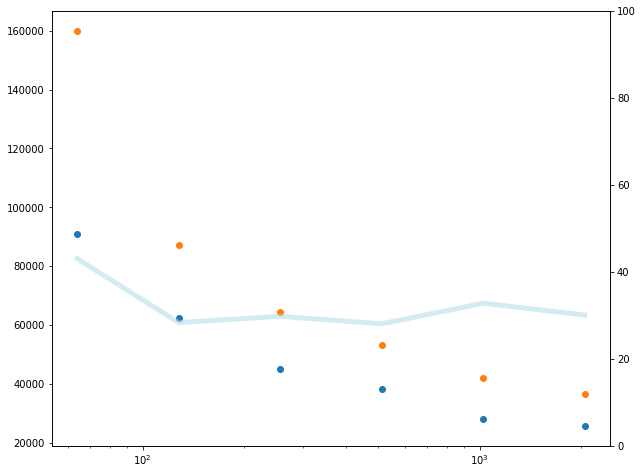

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,8))
l1 = ax.scatter(initialcon, sepnet_total, label = "sepnet absolute error")
l2 = ax.scatter(initialcon, net_total, label = "net absolute error")
# ax.set_ylabel('absolute error')
ax2 = ax.twinx()
l3 = ax2.plot(initialcon, np.maximum(np.zeros(6), (np.array(net_total)-np.array(sepnet_total))/np.array(net_total)*100), color = "lightblue", linewidth = 5.0, alpha = 0.5, label = "percentage error reduction")
# ax2.set_ylabel('percentage error reduction')
ax2.set_ylim(0,100)
plt.xscale("log")
# fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

In [ ]:
# import matplotlib.pyplot as plt
# from torch.autograd import Variable
# from matplotlib import cm
# from understandingPINNs.models import PINN
# import torch
# from understandingPINNs import metrics

# for i in range(20):
#   seed = i
#   np.random.seed(seed=seed)
#   for ini in initialcon: 

#     start, final = groundtruth_2dim.CreateTrainingDataTrajStormer(1,ini,spacedim,h,f1,f2,seed = seed,n_h = 1)

#     delta = (final-start)/0.1
#     delta2 = delta.copy()
#     delta2[0,:] = f1(start)
#     delta2[1,:] = f2(start)
#     dq_MSE = np.mean(np.square(delta2[0,:]-delta[0,:]))
#     dp_MSE = np.mean(np.square(delta2[1,:]-delta[1,:]))
#     data_MSE = np.mean(np.square(np.sqrt(delta[0,:]**2 + delta[1,:]**2)-np.sqrt(delta2[0,:]**2 + delta2[1,:]**2)))

#     """# sumNN"""

    

#     if torch.cuda.is_available():
#       device=torch.device('cuda')
#     else:
#       device=torch.device('cpu')
#     print("device used", device)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)

#     wholemat, evalmat = PINN.data_preprocessing(start, delta,device)    

#     import torch.optim as optim
#     import time 


#     sumnet = PINN.SumNet(2,16,2)
#     starttime = time.time() 

#     results = PINN.train(sumnet,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
#     sumnet, epochs = results[0], results[1]
#     septraintime = time.time()-starttime
#     torch.save(sumnet.state_dict(), '/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.pt' %(sys,sys,"sumNN",seed,ini))

#     H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
#     for i in tqdm(range(len(sample_points))):
#       out = get_H_grad(sumnet, sample_points[i], device)
#       H_pred[i] = out[0]
#       dq_pred[i] = out[1]
#       dp_pred[i] = out[2]
#     print(H_pred.shape, dq_pred.shape, dp_pred.shape)
#     file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_results.txt' %(sys,sys), 'a') 
#     file_object.write('sumNN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
#           %(ini, seed, dq_MSE, dp_MSE, data_MSE, septraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
#           np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
#           np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
#     file_object.close()
    
#     H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)

#     plt.figure(figsize = (10,10))
#     plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
#     plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
#     plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "sumNN"))

In [ ]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
from matplotlib import cm
from understandingPINNs.models import PINN
import torch
from understandingPINNs import metrics

for i in [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]:
  seed = i
  np.random.seed(seed=seed)
  for ini in initialcon: 

    start, final = groundtruth_2dim.CreateTrainingDataTrajSympEuler(1,ini,spacedim,h,f1,f2,seed = seed,n_h = 1)

    delta = (final-start)/0.1
    delta2 = delta.copy()
    delta2[0,:] = f1(start)
    delta2[1,:] = f2(start)
    dq_MSE = np.mean(np.square(delta2[0,:]-delta[0,:]))
    dp_MSE = np.mean(np.square(delta2[1,:]-delta[1,:]))
    data_MSE = np.mean(np.square(np.sqrt(delta[0,:]**2 + delta[1,:]**2)-np.sqrt(delta2[0,:]**2 + delta2[1,:]**2)))

    """# sepNN"""

    

    if torch.cuda.is_available():
      device=torch.device('cuda')
    else:
      device=torch.device('cpu')
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    wholemat, evalmat = PINN.data_preprocessing(start, delta,device)    

    import torch.optim as optim
    import time 


    sepnet = PINN.sepNet(1,11,11,1)
    starttime = time.time() 

    results = PINN.train(sepnet,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
    sepnet, epochs = results[0], results[1]
    septraintime = time.time()-starttime
    torch.save(sepnet.state_dict(), '/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.pt' %(sys,sys,"sepNN",seed,ini))

    H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    for i in tqdm(range(len(sample_points))):
      out = get_H_grad(sepnet, sample_points[i], device)
      H_pred[i] = out[0]
      dq_pred[i] = out[1]
      dp_pred[i] = out[2]
    print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_results.txt' %(sys,sys), 'a') 
    file_object.write('sepNN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
          %(ini, seed, dq_MSE, dp_MSE, data_MSE, septraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
          np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
          np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    file_object.close()
    
    H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)

    plt.figure(figsize = (10,10))
    plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "sepNN"))

    net = PINN.Net(2,16,1)
    starttime = time.time() 
    
    results = PINN.train(net,bs=10,num_epoch=5000,initial_conditions=initialcon,device=device, wholemat=wholemat,evalmat=evalmat,x0=x0,H0=H0,dim=dim,LR=LR,patience=100,c1=1,c2=1,c3=1,c4=1)
    net, epochs = results[0], results[1]
    PINNtraintime = time.time()-starttime
    torch.save(net.state_dict(), '/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.pt' %(sys,sys,"PINN",seed,ini))

    H_pred, dq_pred, dp_pred = np.zeros((H_true.shape)), np.zeros((H_true.shape)), np.zeros((H_true.shape))
    for i in tqdm(range(len(sample_points))):
      out = get_H_grad(net, sample_points[i], device)
      H_pred[i] = out[0]
      dq_pred[i] = out[1]
      dp_pred[i] = out[2]
    print(H_pred.shape, dq_pred.shape, dp_pred.shape)
    file_object = open('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_results.txt' %(sys,sys), 'a')
    file_object.write('PINN, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s \n' 
          %(ini, seed, dq_MSE, dp_MSE, data_MSE, PINNtraintime, epochs, metrics.MSE(H_pred, H_true, diagdist), metrics.MSE(dq_pred, f1(np.squeeze(sample_points,2).transpose()), diagdist), metrics.MSE(dp_pred, f2(np.squeeze(sample_points,2).transpose()), diagdist),
          np.mean(np.square(H_pred- H_true)), np.mean(np.square(dq_pred- f1(np.squeeze(sample_points,2).transpose()))), np.mean(np.square(dp_pred- f2(np.squeeze(sample_points,2).transpose()))), 
          np.mean(np.square(np.sqrt(dq_pred**2 + dp_pred**2)-np.sqrt(f1(np.squeeze(sample_points,2).transpose())**2 + f2(np.squeeze(sample_points,2).transpose())**2)))))
    file_object.close()
    
    H_pred, dq_pred, dp_pred = H_pred.reshape(xshort.shape), dq_pred.reshape(xshort.shape), dp_pred.reshape(xshort.shape)
    
    plt.figure(figsize = (10,10))
    plt.quiver(xshort,yshort,dq_pred,dp_pred) #x,y,dH/dy,-dH/dx
    plt.imshow(np.flip(H_pred.reshape(xshort.shape),0), cmap = cm.jet, extent = (spacedim[0][0], spacedim[0][1], spacedim[1][0], spacedim[1][1]))
    plt.savefig('/content/drive/MyDrive/CIKM2022/SeparableExp/%s (euler)/%s_%s_%s_%s.png' %(sys,sys, ini, seed, "PINN"))

    print(septraintime, PINNtraintime)